<a href="https://colab.research.google.com/github/pragmalingu/experiments/blob/master/01_Stemming/Experiment/First_Experiment_Stemming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First Experiment

For our first experiment we created a Google Colab Notebook that runs an Elasticsearch instance and compared the standard Elasticsearch analyzer with two built-in stemming methods: 'Stemmer Token Filter' and 'Hunspell Token Filter'. 
(To read details about this experiment visit our [website](https://pragmalingu.de/docs/experiments/experiment1))

## Setup an Elasticsearch Instance in Google Colab

Download elasticsearch and import dependencies:

In [1]:
import os
import time
from subprocess import Popen, PIPE, STDOUT

# install elasticsearch client
!pip install elasticsearch -q
from elasticsearch import Elasticsearch
from datetime import datetime

# download elasticsearch server
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.1-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.9.1-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.9.1

     |████████████████████████████████| 327kB 7.3MB/s 


Start a local server inside the colab runtime:

In [2]:
# start server
es_server = Popen(['elasticsearch-7.9.1/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )

# connect client to server
es = Elasticsearch(["localhost:9200/"])
#wait a bit
time.sleep(30)
es.ping()  # got True

True

## Initialize Stemmers

**Analyzer**

To apply stemming we first need to configure a custom analyzer that makes use of the stemmer token filter. 
An analyzer contains three lower-level [building blocks](https://www.elastic.co/guide/en/elasticsearch/reference/master/analyzer-anatomy.html): character filters, a tokenizer, and token filters. We define our stemming analyzer configurations below and later use them to create and index for each corpus. These indexes will have the default analyzer replaced by our analyzers.


### Algorithmic Stemmer

Algorithmic stemmers apply a series of rules to each word to reduce it to its root form. We are using the [stemmer tokenfilter](https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-stemmer-tokenfilter.html#analysis-stemmer-tokenfilter) that is included in Elasticsearch an contains stemmers for several languages.

Algorithmic stemmers present a few advantages:
1. They require little setup and usually work well out of the box;
2. They use little memory;
3. They are typically faster than dictionary stemmers.

(For more information see the [Elasticsearch documentation](https://www.elastic.co/guide/en/elasticsearch/reference/current/stemming.html#algorithmic-stemmers))

In [3]:
#the order of filter and analyzer is arbitrary
stemming_analyzer = {
    "filter" : {
        "eng_stemmer" : {
        "type" : "stemmer",
        "name" : "english"
        }
    },
    "analyzer" : {
        "default" : {
            "tokenizer" : "standard",
            "filter" : ["lowercase", "eng_stemmer"]
        }
    }
}

#create the corresponding index settings 
stemmer_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0,
        "analysis": stemming_analyzer
    }
}

### Dictionary Stemmer

Dictionary stemmers look up words in a provided dictionary, replacing unstemmed word variants with stemmed words from the dictionary. We are using the [Hunspell Token Filter](https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-hunspell-tokenfilter.html) that is included in Elasticsearch.

In theory, these are well suited for:  
1. Stemming irregular words;
2. Discerning between words that are spelled similarly but not related conceptually.

They also admit a few drawbacks:
1. Highly dependent on dictionary quality;
2. Size and performance, as a result of having to load all words, prefixes and suffixes from the dictionary.

(For more information see the [Elasticsearch documentation](https://www.elastic.co/guide/en/elasticsearch/reference/current/stemming.html#dictionary-stemmers))

In [4]:
#the order of filter and analyzer is arbitrary
dictionary_analyzer = {
    "filter" : {
        "dictionary_stemmer" : {
          "type" : "hunspell",
          "locale" : "en_US",
          "dedup" : True  #duplicate tokens are removed from the filter’s output
        }
    },
    "analyzer" : {
        "default" : {
            "tokenizer" : "standard",
            "filter" : ["lowercase", "dictionary_stemmer"]
        }
    }
}

#create the correct index settings 
hunspell_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0,
        "analysis": dictionary_analyzer
    }
}

**Dictionary**

To use the Hunspell Token Stemmer for English US you have to download a Hunspell dictionary for that language and make it accessable for your Elasticsearch instance at 'elsaticsearch-7.9.1/ect/elasticsearch/hunspell/en_US'. We used the dictionaries that are used for spellchecking in libreoffice:
(For more information visit the [Elasticsearch Website](https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-hunspell-tokenfilter.html#analysis-hunspell-tokenfilter-dictionary-config))

In [5]:
!wget https://cgit.freedesktop.org/libreoffice/dictionaries/plain/en/en_US.aff -P /content/elasticsearch-7.9.1/config/hunspell/en_US
!wget https://cgit.freedesktop.org/libreoffice/dictionaries/plain/en/en_US.dic -P /content/elasticsearch-7.9.1/config/hunspell/en_US

--2020-12-06 10:24:15--  https://cgit.freedesktop.org/libreoffice/dictionaries/plain/en/en_US.aff
Resolving cgit.freedesktop.org (cgit.freedesktop.org)... 131.252.210.161
Connecting to cgit.freedesktop.org (cgit.freedesktop.org)|131.252.210.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3090 (3.0K) [text/plain]
Saving to: ‘/content/elasticsearch-7.9.1/config/hunspell/en_US/en_US.aff’

en_US.aff           100%[===================>]   3.02K  --.-KB/s    in 0s      

2020-12-06 10:24:15 (64.9 MB/s) - ‘/content/elasticsearch-7.9.1/config/hunspell/en_US/en_US.aff’ saved [3090/3090]

--2020-12-06 10:24:15--  https://cgit.freedesktop.org/libreoffice/dictionaries/plain/en/en_US.dic
Resolving cgit.freedesktop.org (cgit.freedesktop.org)... 131.252.210.161
Connecting to cgit.freedesktop.org (cgit.freedesktop.org)|131.252.210.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 551260 (538K) [text/plain]
Saving to: ‘/content/elasticsearch-7.9

## Process Data

Download different corpora, format them and feed them to Elasticsearch

### ADI Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/adi/).  <br>

**Parsing**

For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/experiments/blob/master/00_Data/ADICorpus.ipynb) or for parsing in generel read [this guide](https://pragmalingu.de/docs/guides/how-to-parse). An overview of the format of the files can be found here: [Data Sets](https://pragmalingu.de/docs/guides/data-comparison)

In [6]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/adi/adi.tar.gz
!tar -xf adi.tar.gz

# set paths to the dowloaded data as variables
PATH_TO_ADI_TXT = '/content/ADI.ALL'
PATH_TO_ADI_QRY = '/content/ADI.QRY'
PATH_TO_ADI_REL = '/content/ADI.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

adi_index = "adi-corpus"

# get the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

adi_txt_list = get_data(PATH_TO_ADI_TXT, ID_marker)
adi_qry_list = get_data(PATH_TO_ADI_QRY, ID_marker)

# process text file

adi_title_start = re.compile('\.T')
adi_author_start = re.compile('\.A')
adi_text_start = re.compile('\.W')

adi_txt_data = defaultdict(dict)

for line in adi_txt_list:
  entries = re.split(adi_title_start,line,1)
  id = entries[0].strip()
  no_id = entries[1]
  if len(re.split(adi_author_start, no_id,1)) > 1:
    no_id_entries = re.split(adi_author_start, no_id,1)
    adi_txt_data[id]['title'] = no_id_entries[0]
    no_title = no_id_entries[1]
    no_title_entries = re.split(adi_text_start, no_title)
    adi_txt_data[id]['author'] = no_title_entries[0]
    adi_txt_data[id]['text'] = no_title_entries[1]
  else:
    no_id_entries = re.split(adi_text_start, no_id)
    adi_txt_data[id]['title'] = no_id_entries[0]
    adi_txt_data[id]['text'] = no_id_entries[1]

# process query file    

qry_chunk_start = re.compile('\.W')
adi_qry_data = defaultdict(dict)

for n in range(0,len(adi_qry_list)-1):
  line = adi_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  adi_qry_data[n+1]['question'] = question

# process relevance assesment

adi_rel_data = open(PATH_TO_ADI_REL)
adi_np = np.loadtxt(adi_rel_data, dtype=float)

adi_rel = defaultdict(list)
for row in adi_np:
  adi_rel[int(row[0])].append(int(row[1])) 

--2020-12-06 10:24:15--  http://ir.dcs.gla.ac.uk/resources/test_collections/adi/adi.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17307 (17K) [application/gzip]
Saving to: ‘adi.tar.gz’

adi.tar.gz          100%[===================>]  16.90K  --.-KB/s    in 0.1s    

2020-12-06 10:24:16 (124 KB/s) - ‘adi.tar.gz’ saved [17307/17307]



**Indexing**

Create an index of the ADI corpus for every test setting and index all the documents. This is only possible if it isn't created yet.

(For more information see the [Elasticsearch documentation](https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create))

In [7]:
#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
adi_index = "adi-corpus"
stemmer_adi_index = "stemmer-adi-corpus"
hunspell_adi_index = "hunspell-adi-corpus"

es.indices.create(adi_index)
es.indices.create(stemmer_adi_index, body=stemmer_settings)
es.indices.create(hunspell_adi_index, body=hunspell_settings)
#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage
for ID, doc_data in adi_txt_data.items():
  es.index(index=adi_index, id=ID, body=doc_data)
  es.index(index=stemmer_adi_index, id=ID, body=doc_data)
  es.index(index=hunspell_adi_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

green  open hunspell-adi-corpus DUgwsRY9Tp-8qnN_XQ5nkQ 1 0 66 0   79kb   79kb
green  open stemmer-adi-corpus  ayMj7BcxQEy25O3JFxFw9A 1 0 73 0   81kb   81kb
yellow open adi-corpus          L2AqnwDeSpGhl_NwlSV4bw 1 1 64 0 77.8kb 77.8kb



### CACM Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/). <br>

**Parsing**

For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/experiments/blob/master/00_Data/CACMCorpus.ipynb) or for parsing in generel read [this guide](https://pragmalingu.de/docs/guides/how-to-parse). An overview of the format of the files can be found here: [Data Sets](https://pragmalingu.de/docs/guides/data-comparison)

In [8]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/cacm.tar.gz
!tar -xf cacm.tar.gz

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_CACM_TXT = '/content/cacm.all'
PATH_TO_CACM_QRY = '/content/query.text'
PATH_TO_CACM_REL = '/content/qrels.text'
PATH_TO_CACM_COMMON_WORDS = '/content/common_words'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

cacm_index = "cacm-corpus"

# get the text and query files

ID_marker = re.compile('^\.I',re.MULTILINE)

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cacm_txt_list = get_data(PATH_TO_CACM_TXT, ID_marker)
cacm_qry_list = get_data(PATH_TO_CACM_QRY, ID_marker)

# process text file

cacm_chunk_title = re.compile('\.[T]\n')
cacm_chunk_txt = re.compile('\n\.W\n') # not enough
cacm_chunk_txt_pub = re.compile('\.[W,B]')
cacm_chunk_publication = re.compile('\.[B]\n')
cacm_chunk_author = re.compile('^\.[A]\n', re.MULTILINE)
cacm_chunk_author_add_cross = re.compile('^\.[A,N,X]\n',re.MULTILINE) # not enough
cacm_chunk_add_cross = re.compile('\.[B,N,X]\n')


cacm_txt_data = defaultdict(dict)

for line in cacm_txt_list:
  entries= re.split(cacm_chunk_title,line)
  id = entries[0].strip() #save id
  no_id = entries[1]

  if len(re.split(cacm_chunk_txt, no_id)) == 2: # is there text
    no_id_entries = re.split(cacm_chunk_txt_pub, no_id,1)
    cacm_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    cacm_txt_data[id]['text'] = no_id_entries[1].strip() # save text
    no_title_txt = no_id_entries[1]

    if len(re.split(cacm_chunk_author, no_title_txt)) == 2: # is there a auhtor
      no_title_entries = re.split(cacm_chunk_author_add_cross, no_title_txt)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['author'] = no_title_entries[1].strip() # save athor
      cacm_txt_data[id]['add_date'] = no_title_entries[2].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[3].strip() # save cross-references

    else:
      no_title_entries = re.split(cacm_chunk_publication, no_title_txt)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['add_date'] = no_title_entries[1].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[1].strip() # save cross-references

  else:
    no_id_entries = re.split(cacm_chunk_publication, no_id,1)
    cacm_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    no_title = no_id_entries[1]

    if len(re.split(cacm_chunk_author, no_title,1)) == 2: # is there a auhtor
      no_title_entries = re.split(cacm_chunk_author_add_cross, no_title)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['author'] = no_title_entries[1].strip() # save athor
      cacm_txt_data[id]['add_date'] = no_title_entries[2].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[3].strip() # save cross-references

    else:
      no_title_entries = re.split(cacm_chunk_add_cross, no_title)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['add_date'] = no_title_entries[1].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[2].strip() # save cross-references

# process the query data

qry_chunk_start = re.compile('^\.W\n',re.MULTILINE)
cacm_qry_data = defaultdict(dict)

for n in range(0,len(cacm_qry_list)-1):
  line = cacm_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  cacm_qry_data[n+1]['question'] = question

# process the relevance assesment data
cacm_rel = defaultdict(list)

with open (PATH_TO_CACM_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    cacm_rel[int(line[0])].append(line[1])

--2020-12-06 10:24:22--  http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/cacm.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 705665 (689K) [application/gzip]
Saving to: ‘cacm.tar.gz’

cacm.tar.gz         100%[===================>] 689.13K   966KB/s    in 0.7s    

2020-12-06 10:24:23 (966 KB/s) - ‘cacm.tar.gz’ saved [705665/705665]



**Indexing**

Create an index of the CACM corpus for every test setting and index all the documents. This is only possible if it isn't created yet.

(For more information see the [Elasticsearch documentation](https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create))

In [9]:
#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
cacm_index = "cacm-corpus"
stemmer_cacm_index = "stemmer-cacm-corpus"
hunspell_cacm_index = "hunspell-cacm-corpus"

es.indices.create(cacm_index)
es.indices.create(stemmer_cacm_index, body=stemmer_settings)
es.indices.create(hunspell_cacm_index, body=hunspell_settings)
#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage
for ID, doc_data in cacm_txt_data.items():
  es.index(index=cacm_index, id=ID, body=doc_data)
  es.index(index=stemmer_cacm_index, id=ID, body=doc_data)
  es.index(index=hunspell_cacm_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

green  open hunspell-cacm-corpus 8Owz5DsnQ8-Fn5yYcW9FaA 1 0 922 0   2.4mb   2.4mb
green  open hunspell-adi-corpus  DUgwsRY9Tp-8qnN_XQ5nkQ 1 0  82 0 100.5kb 100.5kb
green  open stemmer-adi-corpus   ayMj7BcxQEy25O3JFxFw9A 1 0  82 0  95.3kb  95.3kb
yellow open cacm-corpus          jnUqncb-TZm39ZbD8pa8Og 1 1 875 0   1.9mb   1.9mb
yellow open adi-corpus           L2AqnwDeSpGhl_NwlSV4bw 1 1  82 0   101kb   101kb
green  open stemmer-cacm-corpus  kMam3YGMTw-poif860SssA 1 0 882 0   1.9mb   1.9mb



### CISI Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/).  <br>

**Parsing** 

For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/experiments/blob/master/00_Data/CISICorpus.ipynb) or for parsing in generel read [this guide](https://pragmalingu.de/docs/guides/how-to-parse). An overview of the format of the files can be found here: [Data Sets](https://pragmalingu.de/docs/guides/data-comparison)

In [10]:

# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/cisi.tar.gz
!tar -xf cisi.tar.gz

# set paths to the dowloaded data as variablesDownload and unzip data.
PATH_TO_CISI_TXT = '/content/CISI.ALL'
PATH_TO_CISI_QRY = '/content/CISI.QRY'
PATH_TO_CISI_REL = '/content/CISI.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

cisi_index = "cisi-corpus"

# get the text and query files

ID_marker = re.compile('^\.I',re.MULTILINE)

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cisi_txt_list = get_data(PATH_TO_CISI_TXT, ID_marker)
cisi_qry_list = get_data(PATH_TO_CISI_QRY, ID_marker)

# process text file

cisi_title_start = re.compile('[\n]\.T')
cisi_author_start = re.compile('[\n]\.A')
cisi_date_start = re.compile('[\n]\.B')
cisi_text_start = re.compile('[\n]\.W')
cisi_cross_start = re.compile('[\n]\.X')

cisi_txt_data = defaultdict(dict)

for line in cisi_txt_list:
  entries = re.split(cisi_title_start,line,1)
  id = entries[0].strip()#save the id
  no_id = entries[1] 
  
  if len(re.split(cisi_author_start, no_id)) >= 2: # is there just one author?
    no_id_entries = re.split(cisi_author_start, no_id,1)
    cisi_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    no_title = no_id_entries[1]

    if len(re.split(cisi_date_start, no_title)) > 1: # is there a publication date?
      no_title_entries = re.split(cisi_date_start, no_title)
      cisi_txt_data[id]['author'] = no_title_entries[0].strip() # save athour
      no_author = no_title_entries[1]
      no_author_entries = re.split(cisi_text_start, no_author)
      cisi_txt_data[id]['publication_date'] = no_author_entries[0].strip() # save publication date
      no_author_date = no_author_entries[1]
    else:
      no_title_entries = re.split(cisi_text_start, no_title)
      cisi_txt_data[id]['author'] = no_title_entries[0].strip() # save athour
      no_author_date = no_title_entries[1]

  else:
    no_id_entries = re.split(cisi_author_start, no_id)
    cisi_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    cisi_txt_data[id]['author'] = no_id_entries[1].strip() # save first author
    no_title_entries = re.split(cisi_text_start, no_title)
    cisi_txt_data[id]['author'] += ','+no_title_entries[0].strip() # save second athour
    no_author_date = no_title_entries[1]

  last_entries = re.split(cisi_cross_start, no_author_date)
  cisi_txt_data[id]['text'] = last_entries[0].strip() # save text
  cisi_txt_data[id]['cross-refrences'] = last_entries[1].strip() # save cross refrences

# process query file  

qry_chunk_start = re.compile('[\n]\.W')

cisi_qry_data = defaultdict(dict)

for line in cisi_qry_list:
  id , question = re.split(qry_chunk_start,line)
  id = re.findall('\d{1,3}',id)[0]
  cisi_qry_data[id]['question'] = question

# process the relevance assesment data
cisi_rel = defaultdict(list)

with open (PATH_TO_CISI_REL,'r') as f:
  for line in f:
    line = line.replace(' ','\t')
    line = re.split('\t',line)
    line = list(filter(None, line))
    cisi_rel[str(line[0])].append(str(line[1]))

--2020-12-06 10:26:05--  http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/cisi.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 775144 (757K) [application/gzip]
Saving to: ‘cisi.tar.gz’

cisi.tar.gz         100%[===================>] 756.98K   922KB/s    in 0.8s    

2020-12-06 10:26:06 (922 KB/s) - ‘cisi.tar.gz’ saved [775144/775144]



**Indexing**

Create an index of the CISI corpus for every test setting and index all the documents. This is only possible if it isn't created yet.

(For more information see the [Elasticsearch documentation](https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create))

In [11]:
#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
cisi_index = "cisi-corpus"
stemmer_cisi_index = "stemmer-cisi-corpus"
hunspell_cisi_index = "hunspell-cisi-corpus"

es.indices.create(cisi_index)
es.indices.create(stemmer_cisi_index, body=stemmer_settings)
es.indices.create(hunspell_cisi_index, body=hunspell_settings)
#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage
for ID, doc_data in cisi_txt_data.items():
  es.index(index=cisi_index, id=ID, body=doc_data)
  es.index(index=stemmer_cisi_index, id=ID, body=doc_data)
  es.index(index=hunspell_cisi_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

green  open hunspell-cisi-corpus HzgbXUupTzCJotJwXhpoLw 1 0 985 0   3.4mb   3.4mb
green  open hunspell-cacm-corpus 8Owz5DsnQ8-Fn5yYcW9FaA 1 0 922 0   2.4mb   2.4mb
green  open hunspell-adi-corpus  DUgwsRY9Tp-8qnN_XQ5nkQ 1 0  82 0 100.5kb 100.5kb
green  open stemmer-adi-corpus   ayMj7BcxQEy25O3JFxFw9A 1 0  82 0  95.3kb  95.3kb
yellow open cacm-corpus          jnUqncb-TZm39ZbD8pa8Og 1 1 875 0   1.9mb   1.9mb
yellow open cisi-corpus          99ZBsylYTa2CAzp1MqJyVg 1 1 970 0   3.5mb   3.5mb
green  open stemmer-cisi-corpus  DmxGfwjmRdqtIsWErYSPtQ 1 0 979 0   3.3mb   3.3mb
yellow open adi-corpus           L2AqnwDeSpGhl_NwlSV4bw 1 1  82 0   101kb   101kb
green  open stemmer-cacm-corpus  kMam3YGMTw-poif860SssA 1 0 882 0   1.9mb   1.9mb



### Cranfield Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cran/).  <br>


**Parsing**

For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/experiments/blob/master/00_Data/CranfieldCorpus.ipynb) or for parsing in generel read [this guide](https://pragmalingu.de/docs/guides/how-to-parse). An overview of the format of the files can be found here: [Data Sets](https://pragmalingu.de/docs/guides/data-comparison)

In [12]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz
!tar -xf cran.tar.gz

# set paths to the dowloaded data as variables
PATH_TO_CRAN_TXT = '/content/cran.all.1400'
PATH_TO_CRAN_QRY = '/content/cran.qry'
PATH_TO_CRAN_REL = '/content/cranqrel'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

cran_index = "cranfield-corpus"

# get the text entries from the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cran_txt_list = get_data(PATH_TO_CRAN_TXT, ID_marker)
cran_qry_list = get_data(PATH_TO_CRAN_QRY, ID_marker)

# process text file

cran_chunk_start = re.compile('\.[A,B,T,W]')
cran_txt_data = defaultdict(dict)

for line in cran_txt_list:
  entries= re.split(cran_chunk_start,line)
  id = entries[0].strip()
  title = entries[1]
  author = entries[2]
  publication_date = entries[3]
  text = entries[4:]
  cran_txt_data[id]['title'] = ''.join(title)
  cran_txt_data[id]['author'] = author
  cran_txt_data[id]['publication_date'] = publication_date
  cran_txt_data[id]['text'] = ''.join(text)

# process query file

qry_chunk_start = re.compile('\.W')
cran_qry_data = defaultdict(dict)

for n in range(0,len(cran_qry_list)-1):
  line = cran_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  cran_qry_data[n+1]['question'] = question

# process relevance assesments with rating

cran_rel_data = open(PATH_TO_CRAN_REL)
cran_np = np.loadtxt(cran_rel_data, dtype=int)

cran_rel_rat = defaultdict(list)
for row in cran_np:
  cran_rel_rat[row[0]].append(tuple(row[1:])) 

# process relevance assesments without rating
cran_rel = defaultdict(list)

with open (PATH_TO_CRAN_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    cran_rel[int(line[0])].append(line[1])

--2020-12-06 10:26:55--  http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506960 (495K) [application/gzip]
Saving to: ‘cran.tar.gz’

cran.tar.gz         100%[===================>] 495.08K   713KB/s    in 0.7s    

2020-12-06 10:26:56 (713 KB/s) - ‘cran.tar.gz’ saved [506960/506960]



**Indexing**

Create an index of the Cranfield corpus for every test setting and index all the documents. This is only possible if it isn't created yet.

(For more information see the [Elasticsearch documentation](https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create))

In [13]:
#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
cran_index = "cranfield-corpus"
stemmer_cran_index = "stemmer-cranfield-corpus"
hunspell_cran_index = "hunspell-cranfield-corpus"

es.indices.create(cran_index)
es.indices.create(stemmer_cran_index, body=stemmer_settings)
es.indices.create(hunspell_cran_index, body=hunspell_settings)
#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage
for ID, doc_data in cran_txt_data.items():
  es.index(index=cran_index, id=ID, body=doc_data)
  es.index(index=stemmer_cran_index, id=ID, body=doc_data)
  es.index(index=hunspell_cran_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

green  open hunspell-cisi-corpus      HzgbXUupTzCJotJwXhpoLw 1 0 985 0   3.4mb   3.4mb
green  open hunspell-cacm-corpus      8Owz5DsnQ8-Fn5yYcW9FaA 1 0 922 0   2.4mb   2.4mb
green  open hunspell-adi-corpus       DUgwsRY9Tp-8qnN_XQ5nkQ 1 0  82 0 100.5kb 100.5kb
green  open stemmer-adi-corpus        ayMj7BcxQEy25O3JFxFw9A 1 0  82 0  95.3kb  95.3kb
yellow open cranfield-corpus          nHNER5aZR_Oi4RQGU2Vfcw 1 1 962 0   2.5mb   2.5mb
green  open stemmer-cranfield-corpus  IxdJsWIpTk2zwMorSQce8A 1 0 974 0   2.4mb   2.4mb
yellow open cacm-corpus               jnUqncb-TZm39ZbD8pa8Og 1 1 875 0   1.9mb   1.9mb
green  open stemmer-cisi-corpus       DmxGfwjmRdqtIsWErYSPtQ 1 0 979 0   3.3mb   3.3mb
green  open hunspell-cranfield-corpus Ilv8GkaOTUu4xM5GqPue_A 1 0 983 0   2.5mb   2.5mb
yellow open cisi-corpus               99ZBsylYTa2CAzp1MqJyVg 1 1 970 0   3.5mb   3.5mb
green  open stemmer-cacm-corpus       kMam3YGMTw-poif860SssA 1 0 882 0   1.9mb   1.9mb
yellow open adi-corpus                L2Aqn

### LISA Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/lisa/).  <br>

**Parsing**

For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/experiments/blob/master/00_Data/LISACorpus.ipynb) or for parsing in generel read [this guide](https://pragmalingu.de/docs/guides/how-to-parse). An overview of the format of the files can be found here: [Data Sets](https://pragmalingu.de/docs/guides/data-comparison)

In [14]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/lisa/lisa.tar.gz
!tar -xf lisa.tar.gz

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_LISA_TXT = '/content/'
PATH_TO_LISA_QRY = '/content/LISA.QUE'
PATH_TO_LISA_REL = '/content/LISARJ.NUM'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np
import os

lisa_index = "lisa-corpus"

# get the text and query files

file_regex = re.compile('LISA[0-5]')
lisa_files = [i for i in os.listdir(PATH_TO_LISA_TXT) if os.path.isfile(os.path.join(PATH_TO_LISA_TXT,i)) and re.match(file_regex,i)]

txt_entry_marker = re.compile('\*{44}',re.MULTILINE)
qry_entry_marker = re.compile('#')

def get_data(PATH_TO_FILES, marker):
  """
  Reads multiple files and spilts text into entries at the entry marker.
  The 'marker' contains the regex at which we want to split
  Pops last element since it's empty.
  """
  with open (PATH_TO_FILES,'r') as f:
    text = f.read().replace('     ','')
    lines = re.split(marker,text)
    lines.pop()
  return lines

lisa_txt_list = []
for name in lisa_files: 
  lisa_txt_list.extend(get_data(PATH_TO_LISA_TXT+name, txt_entry_marker))

lisa_qry_list = get_data(PATH_TO_LISA_QRY, qry_entry_marker)

# process text file

doc_strip = re.compile('\n?Document {1,2}')

lisa_txt_list_stripped = []
lisa_txt_data = defaultdict(dict)

for el in lisa_txt_list:
  lisa_txt_list_stripped.append(re.sub(doc_strip,'', el))

for entry in lisa_txt_list_stripped:
  parts = entry.split('\n')
  empty_index = parts.index('')
  ID = parts[0].strip(' ')
  title = parts[1:empty_index]
  text = parts[empty_index+1:]
  lisa_txt_data[ID]['title'] = ''.join(title)
  lisa_txt_data[ID]['text'] = ''.join(text)

# process the query data

lisa_qry_data = defaultdict(dict)
# first line is a special case because it doesn't start with a newline
first_line = lisa_qry_list[0]
first_question = ' '.join(first_line[1:])
lisa_qry_data[int(first_line[0])]['question'] = first_question

# after that every line can be handle the same way
for n in range(0,len(lisa_qry_list)-1):
  line = re.split('\n',lisa_qry_list[n+1])
  question = ' '.join(line[2:])
  lisa_qry_data[int(line[1])]['question'] = question

# process the relevance assesment data

# process relevance assesments
lisa_rel = defaultdict(list)

rel_marker = re.compile('            \n        ')
rel_split = re.compile('\n')

with open (PATH_TO_LISA_REL,'r') as f:
  file = f.read().strip('       ').replace('\n','')
  lines = re.split(' ',file)
  lines = list(filter(None, lines))
  n = 0
  while n < len(lines):
    ID = int(lines[n])
    num_rel = int(lines[n+1])
    rels = lines[(n+2):(n+num_rel+2)]
    lisa_rel[ID].extend(rels)
    n = n+1+num_rel+1

--2020-12-06 10:27:38--  http://ir.dcs.gla.ac.uk/resources/test_collections/lisa/lisa.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227725 (1.2M) [application/gzip]
Saving to: ‘lisa.tar.gz’

lisa.tar.gz         100%[===================>]   1.17M  1.40MB/s    in 0.8s    

2020-12-06 10:27:39 (1.40 MB/s) - ‘lisa.tar.gz’ saved [1227725/1227725]



**Indexing**

Create an index of the LISA corpus for every test setting and index all the documents. This is only possible if it isn't created yet.

(For more information see the [Elasticsearch documentation](https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create))

In [15]:
#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
lisa_index = "lisa-corpus"
stemmer_lisa_index = "stemmer-lisa-corpus"
hunspell_lisa_index = "hunspell-lisa-corpus"

es.indices.create(lisa_index)
es.indices.create(stemmer_lisa_index, body=stemmer_settings)
es.indices.create(hunspell_lisa_index, body=hunspell_settings)
#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage
for ID, doc_data in lisa_txt_data.items():
  es.index(index=lisa_index, id=ID, body=doc_data)
  es.index(index=stemmer_lisa_index, id=ID, body=doc_data)
  es.index(index=hunspell_lisa_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

green  open hunspell-cisi-corpus      HzgbXUupTzCJotJwXhpoLw 1 0 985 0   3.4mb   3.4mb
green  open hunspell-cacm-corpus      8Owz5DsnQ8-Fn5yYcW9FaA 1 0 922 0   2.4mb   2.4mb
green  open hunspell-adi-corpus       DUgwsRY9Tp-8qnN_XQ5nkQ 1 0  82 0 100.9kb 100.9kb
green  open stemmer-adi-corpus        ayMj7BcxQEy25O3JFxFw9A 1 0  82 0  95.6kb  95.6kb
yellow open cranfield-corpus          nHNER5aZR_Oi4RQGU2Vfcw 1 1 962 0   2.5mb   2.5mb
green  open stemmer-lisa-corpus       mk6AZyYMQ5GwRjFyN4NrIA 1 0 958 0   3.1mb   3.1mb
green  open stemmer-cranfield-corpus  IxdJsWIpTk2zwMorSQce8A 1 0 974 0   2.4mb   2.4mb
green  open hunspell-cranfield-corpus Ilv8GkaOTUu4xM5GqPue_A 1 0 983 0   2.5mb   2.5mb
green  open stemmer-cacm-corpus       kMam3YGMTw-poif860SssA 1 0 882 0   1.9mb   1.9mb
yellow open adi-corpus                L2AqnwDeSpGhl_NwlSV4bw 1 1  82 0 101.4kb 101.4kb
yellow open lisa-corpus               Qjz1kZpLTFSOL5OGyMLqew 1 1 951 0   3.2mb   3.2mb
green  open hunspell-lisa-corpus      wDxOO

### Medline Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/med/).  <br>


**Parsing**

For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/experiments/blob/master/00_Data/MedlineCorpus.ipynb) or for parsing in generel read [this guide](https://pragmalingu.de/docs/guides/how-to-parse). An overview of the format of the files can be found here: [Data Sets](https://pragmalingu.de/docs/guides/data-comparison)

In [16]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/medl/med.tar.gz
!tar -xf med.tar.gz

# set paths to the dowloaded data as variables
PATH_TO_MED_TXT = '/content/MED.ALL'
PATH_TO_MED_QRY = '/content/MED.QRY'
PATH_TO_MED_REL = '/content/MED.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

med_index = "medline-corpus"

# get the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

med_txt_list = get_data(PATH_TO_MED_TXT, ID_marker)
med_qry_list = get_data(PATH_TO_MED_QRY, ID_marker)

# process the text and query files

qry_chunk_start = re.compile('\.W')

med_txt_data = defaultdict(dict)
med_qry_data = defaultdict(dict)

def fill_dictionary(dictionary, chunk_list, marker, key_name):
  for n in range(0,len(chunk_list)-1):
    line = chunk_list[n+1]
    _ , chunk = re.split(marker,line)
    dictionary[n+1][key_name] = chunk.strip()

fill_dictionary(med_txt_data, med_txt_list, qry_chunk_start, 'text')
fill_dictionary(med_qry_data, med_qry_list, qry_chunk_start, 'question')

# process relevance assesments with rating

med_rel_data = open(PATH_TO_MED_REL)
med_np = np.loadtxt(med_rel_data, dtype=int)

med_rel_rat = defaultdict(list)
for row in med_np:
  med_rel_rat[row[0]].append(row[2])

# process relevance assesments without rating
med_rel = defaultdict(list)

with open (PATH_TO_MED_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    med_rel[int(line[0])].append(line[2])

--2020-12-06 10:30:29--  http://ir.dcs.gla.ac.uk/resources/test_collections/medl/med.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375183 (366K) [application/gzip]
Saving to: ‘med.tar.gz’

med.tar.gz          100%[===================>] 366.39K   648KB/s    in 0.6s    

2020-12-06 10:30:30 (648 KB/s) - ‘med.tar.gz’ saved [375183/375183]



**Indexing**

Create an index of the medline corpus for every test setting and index all the documents. This is only possible if it isn't created yet.

(For more information see the [Elasticsearch documentation](https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create))

In [17]:
#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
med_index = "medline-corpus"
stemmer_med_index = "stemmer-medline-corpus"
hunspell_med_index = "hunspell-medline-corpus"

es.indices.create(med_index)
es.indices.create(stemmer_med_index, body=stemmer_settings)
es.indices.create(hunspell_med_index, body=hunspell_settings)
#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage
for ID, doc_data in med_txt_data.items():
  es.index(index=med_index, id=ID, body=doc_data)
  es.index(index=stemmer_med_index, id=ID, body=doc_data)
  es.index(index=hunspell_med_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

green  open hunspell-cisi-corpus      HzgbXUupTzCJotJwXhpoLw 1 0  985 0   3.4mb   3.4mb
green  open hunspell-adi-corpus       DUgwsRY9Tp-8qnN_XQ5nkQ 1 0   82 0 100.9kb 100.9kb
green  open hunspell-cacm-corpus      8Owz5DsnQ8-Fn5yYcW9FaA 1 0  922 0   2.4mb   2.4mb
green  open stemmer-adi-corpus        ayMj7BcxQEy25O3JFxFw9A 1 0   82 0  95.6kb  95.6kb
green  open stemmer-lisa-corpus       mk6AZyYMQ5GwRjFyN4NrIA 1 0  958 0   3.1mb   3.1mb
yellow open cranfield-corpus          nHNER5aZR_Oi4RQGU2Vfcw 1 1  962 0   2.5mb   2.5mb
green  open stemmer-cranfield-corpus  IxdJsWIpTk2zwMorSQce8A 1 0  974 0   2.4mb   2.4mb
green  open hunspell-cranfield-corpus Ilv8GkaOTUu4xM5GqPue_A 1 0  983 0   2.5mb   2.5mb
yellow open adi-corpus                L2AqnwDeSpGhl_NwlSV4bw 1 1   82 0 101.4kb 101.4kb
green  open stemmer-cacm-corpus       kMam3YGMTw-poif860SssA 1 0  882 0   1.9mb   1.9mb
yellow open medline-corpus            cpFkUuw2RXO2n5FaKIn2gg 1 1 1022 0   1.9mb   1.9mb
yellow open lisa-corpus         

### NPL Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/npl/).  <br>


**Parsing**

For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/experiments/blob/master/00_Data/NPLCorpus.ipynb) or for parsing in generel read [this guide](https://pragmalingu.de/docs/guides/how-to-parse). An overview of the format of the files can be found here: [Data Sets](https://pragmalingu.de/docs/guides/data-comparison)

In [18]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz
!tar -xf npl.tar.gz

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_NPL_TXT = '/content/doc-text'
PATH_TO_NPL_QRY = '/content/query-text'
PATH_TO_NPL_REL = '/content/rlv-ass'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np
import os

npl_index = "npl-corpus"

# get the text, query and rel files

txt_entry_marker = re.compile('\n   /\n')
qry_entry_marker = re.compile('\n/\n')
rel_entry_marker = re.compile('\n   /\n')

def get_data(PATH_TO_FILES, marker):
  """
  Reads multiple files and spilts text into entries at the entry marker.
  The 'marker' contains the regex at which we want to split
  Pops last element since it's empty.
  """
  with open (PATH_TO_FILES,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop()
  return lines

npl_txt_list = get_data(PATH_TO_NPL_TXT, txt_entry_marker)
npl_qry_list = get_data(PATH_TO_NPL_QRY, qry_entry_marker)
npl_rel_list = get_data(PATH_TO_NPL_REL, rel_entry_marker)

# process the documents

npl_txt_data = defaultdict(dict)

for entry in npl_txt_list:
  splitted = entry.split('\n')
  splitted = list(filter(None, splitted))
  ID = splitted[0]
  text = ' '.join(map(str, splitted[1:]))
  npl_txt_data[ID]['text'] = text

# process the queries

npl_qry_data = defaultdict(dict)

for entry in npl_qry_list:
  splitted = entry.split('\n')
  splitted = list(filter(None, splitted))
  ID = int(splitted[0])
  question = ' '.join(map(str, splitted[1:]))
  npl_qry_data[ID]['question'] = question

# process relevance assesments

npl_rel = defaultdict(list)

for entry in npl_rel_list:
  splitted = entry.replace('\n','').split(' ')
  splitted = list(filter(None, splitted))
  ID = int(splitted[0])
  npl_rel[ID].extend(splitted[1:]) 

--2020-12-06 10:31:00--  http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2125168 (2.0M) [application/gzip]
Saving to: ‘npl.tar.gz’

npl.tar.gz          100%[===================>]   2.03M  2.09MB/s    in 1.0s    

2020-12-06 10:31:02 (2.09 MB/s) - ‘npl.tar.gz’ saved [2125168/2125168]



**Indexing**

Create an index of the NPL corpus for every test setting and index all the documents. This is only possible if it isn't created yet.

(For more information see the [Elasticsearch documentation](https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create))

In [19]:
#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
npl_index = "npl-corpus"
stemmer_npl_index = "stemmer-npl-corpus"
hunspell_npl_index = "hunspell-npl-corpus"

es.indices.create(npl_index)
es.indices.create(stemmer_npl_index, body=stemmer_settings)
es.indices.create(hunspell_npl_index, body=hunspell_settings)
#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage
for ID, doc_data in npl_txt_data.items():
  es.index(index=npl_index, id=ID, body=doc_data)
  es.index(index=stemmer_npl_index, id=ID, body=doc_data)
  es.index(index=hunspell_npl_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

green  open hunspell-cisi-corpus      HzgbXUupTzCJotJwXhpoLw 1 0 1460 0   2.5mb   2.5mb
green  open hunspell-adi-corpus       DUgwsRY9Tp-8qnN_XQ5nkQ 1 0   82 0 100.9kb 100.9kb
green  open hunspell-cacm-corpus      8Owz5DsnQ8-Fn5yYcW9FaA 1 0 3204 0   4.2mb   4.2mb
green  open stemmer-npl-corpus        HzqFYueLQreo-UHYHgwbYg 1 0 1070 0   2.6mb   2.6mb
green  open stemmer-adi-corpus        ayMj7BcxQEy25O3JFxFw9A 1 0   82 0  95.6kb  95.6kb
yellow open cranfield-corpus          nHNER5aZR_Oi4RQGU2Vfcw 1 1 1400 0   1.8mb   1.8mb
green  open stemmer-lisa-corpus       mk6AZyYMQ5GwRjFyN4NrIA 1 0 6000 0   4.5mb   4.5mb
green  open stemmer-cranfield-corpus  IxdJsWIpTk2zwMorSQce8A 1 0 1400 0   1.8mb   1.8mb
green  open hunspell-cranfield-corpus Ilv8GkaOTUu4xM5GqPue_A 1 0 1400 0   1.8mb   1.8mb
yellow open adi-corpus                L2AqnwDeSpGhl_NwlSV4bw 1 1   82 0 101.4kb 101.4kb
green  open stemmer-cacm-corpus       kMam3YGMTw-poif860SssA 1 0 3204 0     4mb     4mb
yellow open medline-corpus      

### Time Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/time/).  <br>


**Parsing**

For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/experiments/blob/master/00_Data/TimeCorpus.ipynb) or for parsing in generel read [this guide](https://pragmalingu.de/docs/guides/how-to-parse). An overview of the format of the files can be found here: [Data Sets](https://pragmalingu.de/docs/guides/data-comparison)

In [20]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/time/time.tar.gz
!tar -xf time.tar.gz

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_TIME_TXT = '/content/TIME.ALL'
PATH_TO_TIME_QRY = '/content/TIME.QUE'
PATH_TO_TIME_REL = '/content/TIME.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np
import os

time_index = "time-corpus"

# get the text and query files

txt_entry_marker = re.compile('\*TEXT')
qry_entry_marker = re.compile('\*FIND    ')
def get_data(PATH_TO_FILES, marker):
  """
  Reads multiple files and spilts text into entries at the entry marker.
  The 'marker' contains the regex at which we want to split
  Pops last element since it's empty.
  """
  with open (PATH_TO_FILES,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

time_txt_list = get_data(PATH_TO_TIME_TXT, txt_entry_marker)
time_qry_list = get_data(PATH_TO_TIME_QRY, qry_entry_marker)

# process text file

page_split = re.compile('PAGE \d{3}')

time_txt_data = defaultdict(dict)
ID = 1
for entry in time_txt_list:
  splitted = re.split(page_split,entry)
  time_txt_data[ID]['text'] = splitted[1]
  ID += 1

time_qry_data = defaultdict(dict)
qry_split = re.compile('\n\n ')

for query in time_qry_list:
  entries = re.split(qry_split,query)
  time_qry_data[int(entries[0])]['question'] = entries[1]

# process relevance assesments
time_rel = defaultdict(list)

rel_marker = re.compile('            \n        ')
rel_split = re.compile('\n')

with open (PATH_TO_TIME_REL,'r') as f:
  for lines in f:
    line = lines.strip().replace('   ',' ').replace('  ',' ').split(' ')
    if len(line) > 1:
      time_rel[int(line[0])].extend(line[1:])

--2020-12-06 10:36:21--  http://ir.dcs.gla.ac.uk/resources/test_collections/time/time.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 627965 (613K) [application/gzip]
Saving to: ‘time.tar.gz’

time.tar.gz         100%[===================>] 613.25K   880KB/s    in 0.7s    

2020-12-06 10:36:23 (880 KB/s) - ‘time.tar.gz’ saved [627965/627965]



**Indexing**

Create an index of the Time corpus for every test setting and index all the documents. This is only possible if it isn't created yet.

(For more information see the [Elasticsearch documentation](https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create))

In [21]:
#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
time_index = "time-corpus"
stemmer_time_index = "stemmer-time-corpus"
hunspell_time_index = "hunspell-time-corpus"

es.indices.create(time_index)
es.indices.create(stemmer_time_index, body=stemmer_settings)
es.indices.create(hunspell_time_index, body=hunspell_settings)
#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage
for ID, doc_data in time_txt_data.items():
  es.index(index=time_index, id=ID, body=doc_data)
  es.index(index=stemmer_time_index, id=ID, body=doc_data)
  es.index(index=hunspell_time_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

green  open hunspell-cisi-corpus      HzgbXUupTzCJotJwXhpoLw 1 0 1460 0   2.5mb   2.5mb
green  open hunspell-time-corpus      lyqxlmYaSBWE_7hwmVv-iQ 1 0  392 0   1.7mb   1.7mb
green  open hunspell-cacm-corpus      8Owz5DsnQ8-Fn5yYcW9FaA 1 0 3204 0   4.2mb   4.2mb
green  open hunspell-adi-corpus       DUgwsRY9Tp-8qnN_XQ5nkQ 1 0   82 0 100.9kb 100.9kb
green  open stemmer-npl-corpus        HzqFYueLQreo-UHYHgwbYg 1 0 1070 0   2.6mb   2.6mb
green  open stemmer-adi-corpus        ayMj7BcxQEy25O3JFxFw9A 1 0   82 0  95.6kb  95.6kb
green  open stemmer-lisa-corpus       mk6AZyYMQ5GwRjFyN4NrIA 1 0 6000 0   4.5mb   4.5mb
yellow open cranfield-corpus          nHNER5aZR_Oi4RQGU2Vfcw 1 1 1400 0   1.8mb   1.8mb
green  open stemmer-cranfield-corpus  IxdJsWIpTk2zwMorSQce8A 1 0 1400 0   1.8mb   1.8mb
green  open hunspell-cranfield-corpus Ilv8GkaOTUu4xM5GqPue_A 1 0 1400 0   1.8mb   1.8mb
green  open stemmer-cacm-corpus       kMam3YGMTw-poif860SssA 1 0 3204 0     4mb     4mb
yellow open adi-corpus          

## Evaluation

Since the data is now formatted and indexed, we can test the ranking produced by each configured analyzer with the [Elasticsearch Ranking Evaluation API](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html).

### Recall

In this section we only evaluate the Recall scores.

**Multi Match Query**

Here we evaluate the data with the ["multi_match"](https://pragmalingu.de/docs/experiments/experiment1#standard-elasticsearch) option of elastic search:

In [22]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-simple-query-string-query.html 

import json
from collections import defaultdict

adi_index = 'adi-corpus'
cacm_index = 'cacm-corpus'
cisi_index = 'cisi-corpus'
cran_index = 'cranfield-corpus'
lisa_index = 'lisa-corpus'
med_index = 'medline-corpus'
npl_index = 'npl-corpus'
time_index = 'time-corpus'

#function to get normal match evaluation body 
def create_query_body_match_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests": '',
      "metric": {
          "recall": {
              "relevant_rating_threshold": 1,
              "k": 20
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : ["title","text"]}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


#ADI
adi_create_match_recall = create_query_body_match_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_match_recall = json.dumps(adi_create_match_recall)
adi_res_match_recall = es.rank_eval(adi_eval_body_match_recall, adi_index)
#print(json.dumps(adi_res_match_recall, indent=4, sort_keys=True))

#CACM
cacm_create_match_recall = create_query_body_match_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_match_recall = json.dumps(cacm_create_match_recall)
cacm_res_match_recall = es.rank_eval(cacm_eval_body_match_recall,cacm_index)
#print(json.dumps(cacm_res_match_recall, indent=4, sort_keys=True))

#CISI
cisi_create_match_recall = create_query_body_match_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_match_recall = json.dumps(cisi_create_match_recall)
cisi_res_match_recall = es.rank_eval(cisi_eval_body_match_recall, cisi_index)
#print(json.dumps(cisi_res_match_recall, indent=4, sort_keys=True))

#Cranfield
cran_create_match_recall = create_query_body_match_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_match_recall = json.dumps(cran_create_match_recall)
cran_res_match_recall = es.rank_eval(cran_eval_body_match_recall, cran_index)
#print(json.dumps(cran_res_match_recall, indent=4, sort_keys=True))

#LISA
lisa_create_match_recall = create_query_body_match_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_match_recall = json.dumps(lisa_create_match_recall)
lisa_res_match_recall = es.rank_eval(lisa_eval_body_match_recall,lisa_index)
#print(json.dumps(lisa_res_match_recall, indent=4, sort_keys=True))

#Medline
med_create_match_recall = create_query_body_match_recall(med_qry_data, med_rel, med_index)
med_eval_body_match_recall = json.dumps(med_create_match_recall)
med_res_match_recall = es.rank_eval(med_eval_body_match_recall, med_index)
#print(json.dumps(med_res_match_recall, indent=4, sort_keys=True))

#NPL
npl_create_match_recall = create_query_body_match_recall(npl_qry_data, npl_rel, npl_index)
npl_eval_body_match_recall = json.dumps(npl_create_match_recall)
npl_res_match_recall = es.rank_eval(npl_eval_body_match_recall,npl_index)
#print(json.dumps(npl_res_match_recall, indent=4, sort_keys=True))

#TIME
time_create_match_recall = create_query_body_match_recall(time_qry_data, time_rel, time_index)
time_eval_body_match_recall = json.dumps(time_create_match_recall)
time_res_match_recall = es.rank_eval(time_eval_body_match_recall,time_index)
#print(json.dumps(time_res_match_recall, indent=4, sort_keys=True))

**Stemmer Token Filter**

Here we evaluate the data with the ["stemmer token filter"](https://pragmalingu.de/docs/experiments/experiment1#stemmer-token-filter) option of elastic search:

In [23]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

import json
from collections import defaultdict

adi_index = 'stemmer-adi-corpus'
cacm_index = 'stemmer-cacm-corpus'
cisi_index = 'stemmer-cisi-corpus'
cran_index = 'stemmer-cranfield-corpus'
lisa_index = 'stemmer-lisa-corpus'
med_index = 'stemmer-medline-corpus'
npl_index = 'stemmer-npl-corpus'
time_index = 'stemmer-time-corpus'


#function to get normal match evaluation body 
def create_query_body_stemming_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "recall": {
              "k": 20,
              "relevant_rating_threshold": 1
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : ["title","text"]}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


#ADI
adi_create_stemming_recall = create_query_body_stemming_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_stemming_recall = json.dumps(adi_create_stemming_recall)
adi_res_stemming_recall = es.rank_eval(adi_eval_body_stemming_recall, adi_index)
#print(json.dumps(adi_res_stemming_recall, indent=4, sort_keys=True))

#CACM
cacm_create_stemming_recall = create_query_body_stemming_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_stemming_recall = json.dumps(cacm_create_stemming_recall)
cacm_res_stemming_recall = es.rank_eval(cacm_eval_body_stemming_recall,cacm_index)
#print(json.dumps(cacm_res_stemming_recall, indent=4, sort_keys=True))

#CISI
cisi_create_stemming_recall = create_query_body_stemming_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_stemming_recall = json.dumps(cisi_create_stemming_recall)
cisi_res_stemming_recall = es.rank_eval(cisi_eval_body_stemming_recall, cisi_index)
#print(json.dumps(cisi_res_stemming_recall, indent=4, sort_keys=True))

#Cranfield
cran_create_stemming_recall = create_query_body_stemming_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_stemming_recall = json.dumps(cran_create_stemming_recall)
cran_res_stemming_recall = es.rank_eval(cran_eval_body_stemming_recall, cran_index)
#print(json.dumps(cran_res_stemming_recall, indent=4, sort_keys=True))

#LISA
lisa_create_stemming_recall = create_query_body_stemming_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_stemming_recall = json.dumps(lisa_create_stemming_recall)
lisa_res_stemming_recall = es.rank_eval(lisa_eval_body_stemming_recall,lisa_index)
#print(json.dumps(lisa_res_stemming_recall, indent=4, sort_keys=True))

#Medline
med_create_stemming_recall = create_query_body_stemming_recall(med_qry_data, med_rel, med_index)
med_eval_body_stemming_recall = json.dumps(med_create_stemming_recall)
med_res_stemming_recall = es.rank_eval(med_eval_body_stemming_recall, med_index)
#print(json.dumps(med_res_stemming_recall, indent=4, sort_keys=True))

#NPL
npl_create_stemming_recall = create_query_body_stemming_recall(npl_qry_data, npl_rel, npl_index)
npl_eval_body_stemming_recall = json.dumps(npl_create_stemming_recall)
npl_res_stemming_recall = es.rank_eval(npl_eval_body_stemming_recall,npl_index)
#print(json.dumps(npl_res_stemming_recall, indent=4, sort_keys=True))

#TIME
time_create_stemming_recall = create_query_body_stemming_recall(time_qry_data, time_rel, time_index)
time_eval_body_stemming_recall = json.dumps(time_create_stemming_recall)
time_res_stemming_recall = es.rank_eval(time_eval_body_stemming_recall,time_index)
#print(json.dumps(time_res_stemming_recallime_res, indent=4, sort_keys=True))

**Hunspell Token Filter**

Here we evaluate the data with the ["hunspell token filter"](https://pragmalingu.de/docs/experiments/experiment1#hunspell-token-filter) option of elastic search:

In [24]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

import json
from collections import defaultdict

adi_index = 'hunspell-adi-corpus'
cacm_index = 'hunspell-cacm-corpus'
cisi_index = 'hunspell-cisi-corpus'
cran_index = 'hunspell-cranfield-corpus'
lisa_index = 'hunspell-lisa-corpus'
med_index = 'hunspell-medline-corpus'
npl_index = 'hunspell-npl-corpus'
time_index = 'hunspell-time-corpus'

#function to get normal match evaluation body 
def create_query_body_hunspell_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "recall": {
              "k": 20,
              "relevant_rating_threshold": 1
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : ["title","text"]}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

#ADI
adi_create_hunspell_recall = create_query_body_hunspell_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_hunspell_recall = json.dumps(adi_create_hunspell_recall)
adi_res_hunspell_recall = es.rank_eval(adi_eval_body_hunspell_recall, adi_index)
#print(json.dumps(adi_res_hunspell_recall, indent=4, sort_keys=True))

#CACM
cacm_create_hunspell_recall = create_query_body_hunspell_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_hunspell_recall = json.dumps(cacm_create_hunspell_recall)
cacm_res_hunspell_recall = es.rank_eval(cacm_eval_body_hunspell_recall,cacm_index)
#print(json.dumps(cacm_res_hunspell_recall, indent=4, sort_keys=True))

#CISI
cisi_create_hunspell_recall = create_query_body_hunspell_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_hunspell_recall = json.dumps(cisi_create_hunspell_recall)
cisi_res_hunspell_recall = es.rank_eval(cisi_eval_body_hunspell_recall, cisi_index)
#print(json.dumps(cisi_res_hunspell_recall, indent=4, sort_keys=True))

#Cranfield
cran_create_hunspell_recall = create_query_body_hunspell_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_hunspell_recall = json.dumps(cran_create_hunspell_recall)
cran_res_hunspell_recall = es.rank_eval(cran_eval_body_hunspell_recall, cran_index)
#print(json.dumps(cran_res_hunspell_recall, indent=4, sort_keys=True))

#LISA
lisa_create_hunspell_recall = create_query_body_hunspell_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_hunspell_recall = json.dumps(lisa_create_hunspell_recall)
lisa_res_hunspell_recall = es.rank_eval(lisa_eval_body_hunspell_recall,lisa_index)
#print(json.dumps(lisa_res_hunspell_recall, indent=4, sort_keys=True))

#Medline
med_create_hunspell_recall = create_query_body_hunspell_recall(med_qry_data, med_rel, med_index)
med_eval_body_hunspell_recall = json.dumps(med_create_hunspell_recall)
med_res_hunspell_recall = es.rank_eval(med_eval_body_hunspell_recall, med_index)
#print(json.dumps(med_res_hunspell_recall, indent=4, sort_keys=True))

#NPL
npl_create_hunspell_recall = create_query_body_hunspell_recall(npl_qry_data, npl_rel, npl_index)
npl_eval_body_hunspell_recall = json.dumps(npl_create_hunspell_recall)
npl_res_hunspell_recall = es.rank_eval(npl_eval_body_hunspell_recall,npl_index)
#print(json.dumps(npl_res_hunspell_recall, indent=4, sort_keys=True))

#TIME
time_create_hunspell_recall = create_query_body_hunspell_recall(time_qry_data, time_rel, time_index)
time_eval_body_hunspell_recall = json.dumps(time_create_hunspell_recall)
time_res_hunspell_recall = es.rank_eval(time_eval_body_hunspell_recall,time_index)
#print(json.dumps(time_res_hunspell_recall, indent=4, sort_keys=True))

### Precision

In this section we only evaluate the Precision scores.

**Multi Match Query**

Here we evaluate the data with the ["multi_match"](https://pragmalingu.de/docs/experiments/experiment1#standard-elasticsearch) option of elastic search:

In [25]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict



adi_index = 'adi-corpus'
cacm_index = 'cacm-corpus'
cisi_index = 'cisi-corpus'
cran_index = 'cranfield-corpus'
lisa_index = 'lisa-corpus'
med_index = 'medline-corpus'
npl_index = 'npl-corpus'
time_index = 'time-corpus'

# function to get normal match evaluation body 

def create_query_body_match_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
              "k": 20,
              "relevant_rating_threshold": 1
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : ["title","text"]}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

#ADI
adi_create_match_precision = create_query_body_match_precision(adi_qry_data, adi_rel, adi_index)
adi_eval_body_match_precision = json.dumps(adi_create_match_precision)
adi_res_match_precision = es.rank_eval(adi_eval_body_match_precision, adi_index)
#print(json.dumps(adi_res_match_precision, indent=4, sort_keys=True))

#CACM
cacm_create_match_precision = create_query_body_match_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_match_precision = json.dumps(cacm_create_match_precision)
cacm_res_match_precision = es.rank_eval(cacm_eval_body_match_precision,cacm_index)
#print(json.dumps(cacm_res_match_precision, indent=4, sort_keys=True))

#CISI
cisi_create_match_precision = create_query_body_match_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_match_precision = json.dumps(cisi_create_match_precision)
cisi_res_match_precision = es.rank_eval(cisi_eval_body_match_precision, cisi_index)
#print(json.dumps(cisi_res_match_precision, indent=4, sort_keys=True))

#Cranfield
cran_create_match_precision = create_query_body_match_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_match_precision = json.dumps(cran_create_match_precision)
cran_res_match_precision = es.rank_eval(cran_eval_body_match_precision, cran_index)
#print(json.dumps(cran_res_match_precision, indent=4, sort_keys=True))

#LISA
lisa_create_match_precision = create_query_body_match_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_match_precision = json.dumps(lisa_create_match_precision)
lisa_res_match_precision = es.rank_eval(lisa_eval_body_match_precision,lisa_index)
#print(json.dumps(lisa_res_match_precision, indent=4, sort_keys=True))

#Medline
med_create_match_precision = create_query_body_match_precision(med_qry_data, med_rel, med_index)
med_eval_body_match_precision = json.dumps(med_create_match_precision)
med_res_match_precision = es.rank_eval(med_eval_body_match_precision, med_index)
#print(json.dumps(med_res_match_precision, indent=4, sort_keys=True))

#NPL
npl_create_match_precision = create_query_body_match_precision(npl_qry_data, npl_rel, npl_index)
npl_eval_body_match_precision = json.dumps(npl_create_match_precision)
npl_res_match_precision = es.rank_eval(npl_eval_body_match_precision,npl_index)
#print(json.dumps(npl_res_match_precision, indent=4, sort_keys=True))

#TIME
time_create_match_precision = create_query_body_match_precision(time_qry_data, time_rel, time_index)
time_eval_body_match_precision = json.dumps(time_create_match_precision)
time_res_match_precision = es.rank_eval(time_eval_body_match_precision,time_index)
#print(json.dumps(time_res_match_precision, indent=4, sort_keys=True))

**Stemmer Token Filter**

Here we evaluate the data with the ["stemmer token filter"](https://pragmalingu.de/docs/experiments/experiment1#stemmer-token-filter) option of elastic search:

In [26]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'stemmer-adi-corpus'
cacm_index = 'stemmer-cacm-corpus'
cisi_index = 'stemmer-cisi-corpus'
cran_index = 'stemmer-cranfield-corpus'
lisa_index = 'stemmer-lisa-corpus'
med_index = 'stemmer-medline-corpus'
npl_index = 'stemmer-npl-corpus'
time_index = 'stemmer-time-corpus'

#function to get normal match evaluation body 

def create_query_body_stemming_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
              "k": 20,
              "relevant_rating_threshold": 1
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : ["title","text"]}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

#ADI
adi_create_stemming_precision = create_query_body_stemming_precision(adi_qry_data, adi_rel, adi_index)
adi_eval_body_stemming_precision = json.dumps(adi_create_stemming_precision)
adi_res_stemming_precision = es.rank_eval(adi_eval_body_stemming_precision, adi_index)
#print(json.dumps(adi_res_stemming_precision, indent=4, sort_keys=True))

#CACM
cacm_create_stemming_precision = create_query_body_stemming_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_stemming_precision = json.dumps(cacm_create_stemming_precision)
cacm_res_stemming_precision = es.rank_eval(cacm_eval_body_stemming_precision,cacm_index)
#print(json.dumps(cacm_res_stemming_precision, indent=4, sort_keys=True))

#CISI
cisi_create_stemming_precision = create_query_body_stemming_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_stemming_precision = json.dumps(cisi_create_stemming_precision)
cisi_res_stemming_precision = es.rank_eval(cisi_eval_body_stemming_precision, cisi_index)
#print(json.dumps(cisi_res_stemming_precision, indent=4, sort_keys=True))

#Cranfield
cran_create_stemming_precision = create_query_body_stemming_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_stemming_precision = json.dumps(cran_create_stemming_precision)
cran_res_stemming_precision = es.rank_eval(cran_eval_body_stemming_precision, cran_index)
#print(json.dumps(cran_res_stemming_precision, indent=4, sort_keys=True))

#LISA
lisa_create_stemming_precision = create_query_body_stemming_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_stemming_precision = json.dumps(lisa_create_stemming_precision)
lisa_res_stemming_precision = es.rank_eval(lisa_eval_body_stemming_precision,lisa_index)
#print(json.dumps(lisa_res_stemming_precision, indent=4, sort_keys=True))

#Medline
med_create_stemming_precision = create_query_body_stemming_precision(med_qry_data, med_rel, med_index)
med_eval_body_stemming_precision = json.dumps(med_create_stemming_precision)
med_res_stemming_precision = es.rank_eval(med_eval_body_stemming_precision, med_index)
#print(json.dumps(med_res_stemming_precision, indent=4, sort_keys=True))

#NPL
npl_create_stemming_precision = create_query_body_stemming_precision(npl_qry_data, npl_rel, npl_index)
npl_eval_body_stemming_precision= json.dumps(npl_create_stemming_precision)
npl_res_stemming_precision = es.rank_eval(npl_eval_body_stemming_precision,npl_index)
#print(json.dumps(npl_res_stemming_precision, indent=4, sort_keys=True))

#TIME
time_create_stemming_precision = create_query_body_stemming_precision(time_qry_data, time_rel, time_index)
time_eval_body_stemming_precision = json.dumps(time_create_stemming_precision)
time_res_stemming_precision = es.rank_eval(time_eval_body_stemming_precision,time_index)
#print(json.dumps(time_res_stemming_precision, indent=4, sort_keys=True))

**Hunspell Token Filter**

Here we evaluate the data with the ["hunspell token filter"](https://pragmalingu.de/docs/experiments/experiment1#hunspell-token-filter) option of elastic search:

In [27]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'hunspell-adi-corpus'
cacm_index = 'hunspell-cacm-corpus'
cisi_index = 'hunspell-cisi-corpus'
cran_index = 'hunspell-cranfield-corpus'
lisa_index = 'hunspell-lisa-corpus'
med_index = 'hunspell-medline-corpus'
npl_index = 'hunspell-npl-corpus'
time_index = 'hunspell-time-corpus'

#function to get normal match evaluation body 

def create_query_body_hunspell_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
              "k": 20,
              "relevant_rating_threshold": 1
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : ["title","text"]}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


#ADI
adi_create_hunspell_precision = create_query_body_hunspell_precision(adi_qry_data, adi_rel, adi_index)
adi_eval_body_hunspell_precision = json.dumps(adi_create_hunspell_precision)
adi_res_hunspell_precision = es.rank_eval(adi_eval_body_hunspell_precision, adi_index)
#print(json.dumps(adi_res_hunspell_precision, indent=4, sort_keys=True))

#CACM
cacm_create_hunspell_precision = create_query_body_hunspell_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_hunspell_precision = json.dumps(cacm_create_hunspell_precision)
cacm_res_hunspell_precision = es.rank_eval(cacm_eval_body_hunspell_precision,cacm_index)
#print(json.dumps(cacm_res_hunspell_precision, indent=4, sort_keys=True))

#CISI
cisi_create_hunspell_precision = create_query_body_hunspell_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_hunspell_precision = json.dumps(cisi_create_hunspell_precision)
cisi_res_hunspell_precision = es.rank_eval(cisi_eval_body_hunspell_precision, cisi_index)
#print(json.dumps(cisi_res_hunspell_precision, indent=4, sort_keys=True))

#Cranfield
cran_create_hunspell_precision = create_query_body_hunspell_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_hunspell_precision = json.dumps(cran_create_hunspell_precision)
cran_res_hunspell_precision = es.rank_eval(cran_eval_body_hunspell_precision, cran_index)
#print(json.dumps(cran_res_hunspell_precision, indent=4, sort_keys=True))

#LISA
lisa_create_hunspell_precision = create_query_body_hunspell_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_hunspell_precision = json.dumps(lisa_create_hunspell_precision)
lisa_res_hunspell_precision = es.rank_eval(lisa_eval_body_hunspell_precision,lisa_index)
#print(json.dumps(lisa_res_hunspell_precision, indent=4, sort_keys=True))

#Medline
med_create_hunspell_precision = create_query_body_hunspell_precision(med_qry_data, med_rel, med_index)
med_eval_body_hunspell_precision = json.dumps(med_create_hunspell_precision)
med_res_hunspell_precision = es.rank_eval(med_eval_body_hunspell_precision, med_index)
#print(json.dumps(med_res_hunspell_precision, indent=4, sort_keys=True))

#NPL
npl_create_hunspell_precision = create_query_body_hunspell_precision(npl_qry_data, npl_rel, npl_index)
npl_eval_body_hunspell_precision= json.dumps(npl_create_hunspell_precision)
npl_res_hunspell_precision = es.rank_eval(npl_eval_body_hunspell_precision,npl_index)
#print(json.dumps(npl_res_hunspell_precision, indent=4, sort_keys=True))

#TIME
time_create_hunspell_precision = create_query_body_hunspell_precision(time_qry_data, time_rel, time_index)
time_eval_body_hunspell_precision = json.dumps(time_create_hunspell_precision)
time_res_hunspell_precision = es.rank_eval(time_eval_body_hunspell_precision,time_index)
#print(json.dumps(time_res_hunspell_precision, indent=4, sort_keys=True))

## Visualization

The last step is to visualize the data so we can analyze the differences:

### Recall

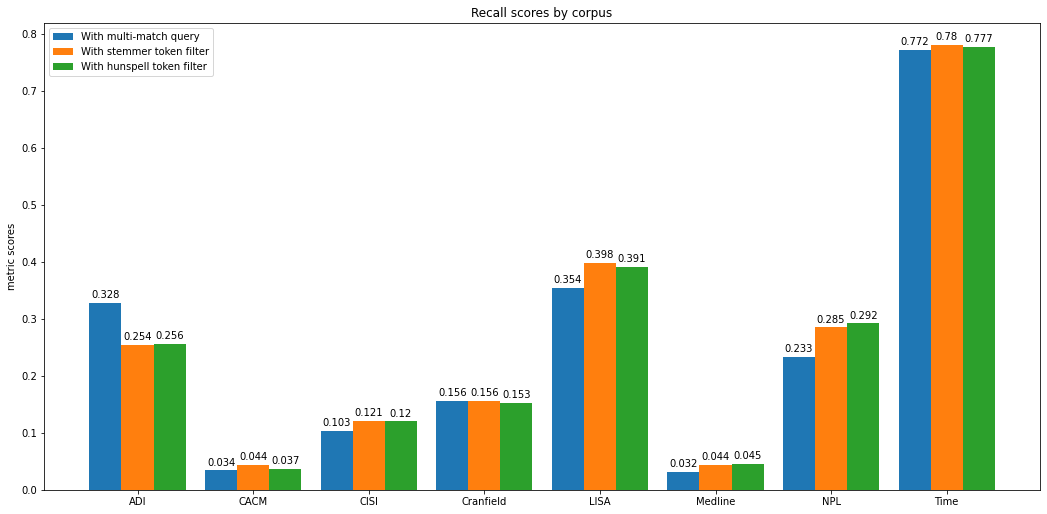

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_recall = []
match_metrics_recall.append(round(adi_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(cacm_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(cisi_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(cran_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(lisa_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(med_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(npl_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(time_res_match_recall['metric_score'], 3))

stemming_metrics_recall = []
stemming_metrics_recall.append(round(adi_res_stemming_recall['metric_score'], 3))
stemming_metrics_recall.append(round(cacm_res_stemming_recall['metric_score'], 3))
stemming_metrics_recall.append(round(cisi_res_stemming_recall['metric_score'], 3))
stemming_metrics_recall.append(round(cran_res_stemming_recall['metric_score'], 3))
stemming_metrics_recall.append(round(lisa_res_stemming_recall['metric_score'], 3))
stemming_metrics_recall.append(round(med_res_stemming_recall['metric_score'], 3))
stemming_metrics_recall.append(round(npl_res_stemming_recall['metric_score'], 3))
stemming_metrics_recall.append(round(time_res_stemming_recall['metric_score'], 3))

hunspell_metrics_recall = []
hunspell_metrics_recall.append(round(adi_res_hunspell_recall['metric_score'], 3))
hunspell_metrics_recall.append(round(cacm_res_hunspell_recall['metric_score'], 3))
hunspell_metrics_recall.append(round(cisi_res_hunspell_recall['metric_score'], 3))
hunspell_metrics_recall.append(round(cran_res_hunspell_recall['metric_score'], 3))
hunspell_metrics_recall.append(round(lisa_res_hunspell_recall['metric_score'], 3))
hunspell_metrics_recall.append(round(med_res_hunspell_recall['metric_score'], 3))
hunspell_metrics_recall.append(round(npl_res_hunspell_recall['metric_score'], 3))
hunspell_metrics_recall.append(round(time_res_hunspell_recall['metric_score'], 3))

labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL','Time']

x = np.arange(len(labels))*1.8  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_recall , width, label='With multi-match query')
rects2 = ax.bar(x, stemming_metrics_recall, width, label='With stemmer token filter')
rects3 = ax.bar(x + width, hunspell_metrics_recall, width, label='With hunspell token filter')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Recall scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [29]:
from tabulate import tabulate

match_metrics_recall.insert(0, 'multi-match query') 
stemming_metrics_recall.insert(0, 'stemmer token filter')
hunspell_metrics_recall.insert(0, 'hunspell token filter')

l = [match_metrics_recall, stemming_metrics_recall, hunspell_metrics_recall]
table = tabulate(l, headers=['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL','Time'], tablefmt='orgtbl')

print(table)

|                       |   ADI |   CACM |   CISI |   Cranfield |   LISA |   Medline |   NPL |   Time |
|-----------------------+-------+--------+--------+-------------+--------+-----------+-------+--------|
| multi-match query     | 0.328 |  0.034 |  0.103 |       0.156 |  0.354 |     0.032 | 0.233 |  0.772 |
| stemmer token filter  | 0.254 |  0.044 |  0.121 |       0.156 |  0.398 |     0.044 | 0.285 |  0.78  |
| hunspell token filter | 0.256 |  0.037 |  0.12  |       0.153 |  0.391 |     0.045 | 0.292 |  0.777 |


### Precision

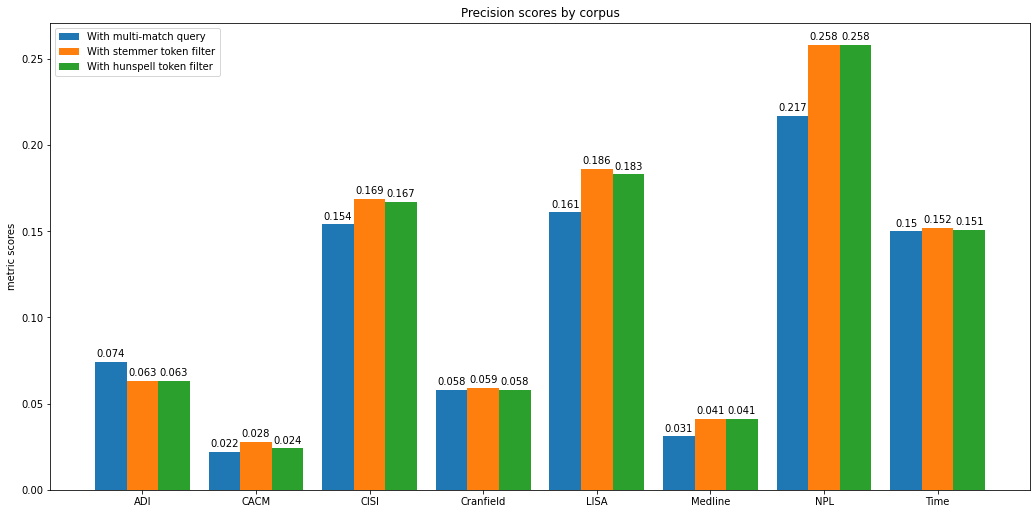

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_precision = []
match_metrics_precision.append(round(adi_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(cacm_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(cisi_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(cran_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(lisa_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(med_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(npl_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(time_res_match_precision['metric_score'], 3))

stemming_metrics_precision = []
stemming_metrics_precision.append(round(adi_res_stemming_precision['metric_score'], 3))
stemming_metrics_precision.append(round(cacm_res_stemming_precision['metric_score'], 3))
stemming_metrics_precision.append(round(cisi_res_stemming_precision['metric_score'], 3))
stemming_metrics_precision.append(round(cran_res_stemming_precision['metric_score'], 3))
stemming_metrics_precision.append(round(lisa_res_stemming_precision['metric_score'], 3))
stemming_metrics_precision.append(round(med_res_stemming_precision['metric_score'], 3))
stemming_metrics_precision.append(round(npl_res_stemming_precision['metric_score'], 3))
stemming_metrics_precision.append(round(time_res_stemming_precision['metric_score'], 3))

hunspell_metrics_precision = []
hunspell_metrics_precision.append(round(adi_res_hunspell_precision['metric_score'], 3))
hunspell_metrics_precision.append(round(cacm_res_hunspell_precision['metric_score'], 3))
hunspell_metrics_precision.append(round(cisi_res_hunspell_precision['metric_score'], 3))
hunspell_metrics_precision.append(round(cran_res_hunspell_precision['metric_score'], 3))
hunspell_metrics_precision.append(round(lisa_res_hunspell_precision['metric_score'], 3))
hunspell_metrics_precision.append(round(med_res_hunspell_precision['metric_score'], 3))
hunspell_metrics_precision.append(round(npl_res_hunspell_precision['metric_score'], 3))
hunspell_metrics_precision.append(round(time_res_hunspell_precision['metric_score'], 3))

labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL','Time']

x = np.arange(len(labels))*1.8  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_precision , width, label='With multi-match query')
rects2 = ax.bar(x, stemming_metrics_precision, width, label='With stemmer token filter')
rects3 = ax.bar(x + width, hunspell_metrics_precision, width, label='With hunspell token filter')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Precision scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [31]:
from tabulate import tabulate

match_metrics_precision.insert(0, 'multi-match query') 
stemming_metrics_precision.insert(0, 'stemmer token filter') 
hunspell_metrics_precision.insert(0, 'hunspell token filter')

l = [match_metrics_precision, stemming_metrics_precision, hunspell_metrics_precision]
table = tabulate(l, headers=['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL','Time'], tablefmt='orgtbl')

print(table)

|                       |   ADI |   CACM |   CISI |   Cranfield |   LISA |   Medline |   NPL |   Time |
|-----------------------+-------+--------+--------+-------------+--------+-----------+-------+--------|
| multi-match query     | 0.074 |  0.022 |  0.154 |       0.058 |  0.161 |     0.031 | 0.217 |  0.15  |
| stemmer token filter  | 0.063 |  0.028 |  0.169 |       0.059 |  0.186 |     0.041 | 0.258 |  0.152 |
| hunspell token filter | 0.063 |  0.024 |  0.167 |       0.058 |  0.183 |     0.041 | 0.258 |  0.151 |


### F-Score

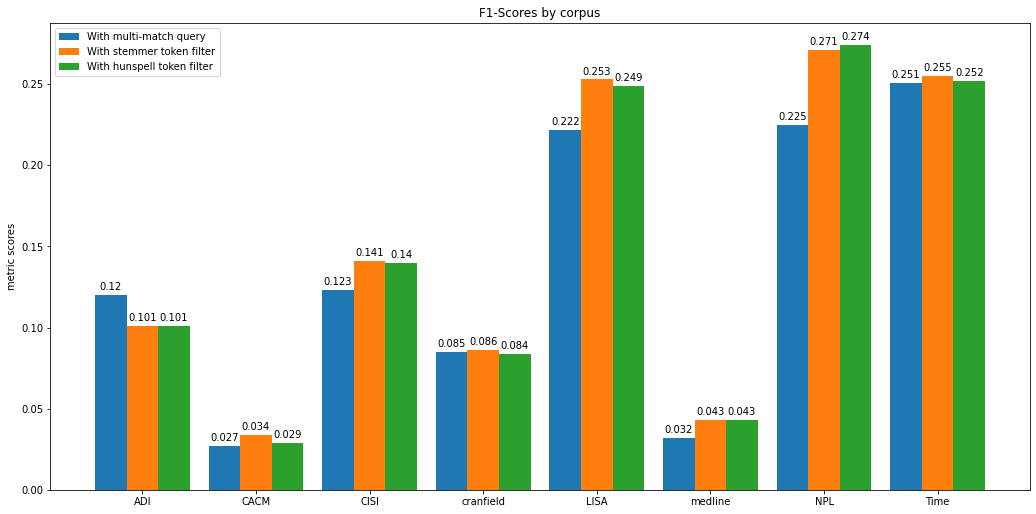

In [32]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def f_score(recall,precision):
  fscore = 2*((recall*precision)/(recall+precision))
  return fscore

match_metrics_fscore = []
match_metrics_fscore.append(round(f_score(adi_res_match_recall['metric_score'], adi_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(cacm_res_match_recall['metric_score'], cacm_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(cisi_res_match_recall['metric_score'], cisi_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(cran_res_match_recall['metric_score'], cran_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(lisa_res_match_recall['metric_score'], lisa_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(med_res_match_recall['metric_score'], med_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(npl_res_match_recall['metric_score'], npl_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(time_res_match_recall['metric_score'], time_res_match_precision['metric_score']),3))

stemming_metrics_fscore = []
stemming_metrics_fscore.append(round(f_score(adi_res_stemming_recall['metric_score'], adi_res_stemming_precision['metric_score']),3))
stemming_metrics_fscore.append(round(f_score(cacm_res_stemming_recall['metric_score'], cacm_res_stemming_precision['metric_score']),3))
stemming_metrics_fscore.append(round(f_score(cisi_res_stemming_recall['metric_score'], cisi_res_stemming_precision['metric_score']),3))
stemming_metrics_fscore.append(round(f_score(cran_res_stemming_recall['metric_score'], cran_res_stemming_precision['metric_score']),3))
stemming_metrics_fscore.append(round(f_score(lisa_res_stemming_recall['metric_score'], lisa_res_stemming_precision['metric_score']),3))
stemming_metrics_fscore.append(round(f_score(med_res_stemming_recall['metric_score'], med_res_stemming_precision['metric_score']),3))
stemming_metrics_fscore.append(round(f_score(npl_res_stemming_recall['metric_score'], npl_res_stemming_precision['metric_score']),3))
stemming_metrics_fscore.append(round(f_score(time_res_stemming_recall['metric_score'], time_res_stemming_precision['metric_score']),3))

hunspell_metrics_fscore = []
hunspell_metrics_fscore.append(round(f_score(adi_res_hunspell_recall['metric_score'], adi_res_hunspell_precision['metric_score']),3))
hunspell_metrics_fscore.append(round(f_score(cacm_res_hunspell_recall['metric_score'], cacm_res_hunspell_precision['metric_score']),3))
hunspell_metrics_fscore.append(round(f_score(cisi_res_hunspell_recall['metric_score'], cisi_res_hunspell_precision['metric_score']),3))
hunspell_metrics_fscore.append(round(f_score(cran_res_hunspell_recall['metric_score'], cran_res_hunspell_precision['metric_score']),3))
hunspell_metrics_fscore.append(round(f_score(lisa_res_hunspell_recall['metric_score'], lisa_res_hunspell_precision['metric_score']),3))
hunspell_metrics_fscore.append(round(f_score(med_res_hunspell_recall['metric_score'], med_res_hunspell_precision['metric_score']),3))
hunspell_metrics_fscore.append(round(f_score(npl_res_hunspell_recall['metric_score'], npl_res_hunspell_precision['metric_score']),3))
hunspell_metrics_fscore.append(round(f_score(time_res_hunspell_recall['metric_score'], time_res_hunspell_precision['metric_score']),3))

labels = ['ADI','CACM', 'CISI','cranfield', 'LISA', 'medline', 'NPL','Time']

x = np.arange(len(labels))*1.8  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_fscore , width, label='With multi-match query')
rects2 = ax.bar(x, stemming_metrics_fscore, width, label='With stemmer token filter')
rects3 = ax.bar(x + width, hunspell_metrics_fscore, width, label='With hunspell token filter')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('F1-Scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [33]:
from tabulate import tabulate

match_metrics_fscore.insert(0, 'multi-match query') 
stemming_metrics_fscore.insert(0, 'stemmer token filter') 
hunspell_metrics_fscore.insert(0, 'hunspell token filter')

l = [match_metrics_fscore, stemming_metrics_fscore, hunspell_metrics_fscore]
table = tabulate(l, headers=['ADI','CACM', 'CISI','cranfield', 'LISA', 'medline', 'NPL','Time'], tablefmt='orgtbl')

print(table)

|                       |   ADI |   CACM |   CISI |   cranfield |   LISA |   medline |   NPL |   Time |
|-----------------------+-------+--------+--------+-------------+--------+-----------+-------+--------|
| multi-match query     | 0.12  |  0.027 |  0.123 |       0.085 |  0.222 |     0.032 | 0.225 |  0.251 |
| stemmer token filter  | 0.101 |  0.034 |  0.141 |       0.086 |  0.253 |     0.043 | 0.271 |  0.255 |
| hunspell token filter | 0.101 |  0.029 |  0.14  |       0.084 |  0.249 |     0.043 | 0.274 |  0.252 |


# Read More
Details on this experiment can be found on our [website](https://pragmalingu.de/docs/experiments/experiment1).